In [1]:
PROJECT_ROOT = './' 


import sys
from os.path import join as ospj
sys.path.append(ospj(PROJECT_ROOT, 'src'))

%load_ext autoreload
%autoreload 2

In this part of assignment 4 we try to
1. implement the forward pass of ViT
2. visualize the attention weights for the final CLS Token.


For evaluation and visualization, we use an 8-class subset (out of 1000) of Imagenet-V2. We use a subset, simply just so that you can run the cells faster.
The model is pre-trained and you just need to download the weights.

Furthermore, most of the relevant modules for ViT, such as the positional embedding, the linear projection, MLP Block, and Multi-head attention are all already implemented. What you mainly have to do is to plug these modules together based on what you've seen in lecture 7 (the ViT slides).

You probably shouldn't need GPU for running this assignment, as there is no training and the dataset is very small and every cell. But of course feel free to change the notebook so that it works on GPU if desired.

In [2]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets

from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm 

from models.vit.model import VisionTransformer
from src.utils.imagenet_names import name_map

## Downloading pre-trained weights

Please Download the weights from `https://download.pytorch.org/models/vit_b_16-c867db91.pth` and place it under `saved/models/vit/vit.pth`. The file size is 330M.


or you can just download and place it by running the cell below (tested on Linux).

In [3]:
!wget "https://download.pytorch.org/models/vit_b_16-c867db91.pth"

# Change the relative paths below to absolute paths if running on Colab
!mkdir -p ../../saved/models/vit
!mv vit_b_16-c867db91.pth ../../saved/models/vit/vit.pth

--2025-06-14 10:50:00--  https://download.pytorch.org/models/vit_b_16-c867db91.pth
Loaded CA certificate '/usr/ssl/certs/ca-bundle.crt'
Resolving download.pytorch.org (download.pytorch.org)... 2600:9000:28c5:d800:d:607e:4540:93a1, 2600:9000:28c5:3000:d:607e:4540:93a1, 2600:9000:28c5:5400:d:607e:4540:93a1, ...
Connecting to download.pytorch.org (download.pytorch.org)|2600:9000:28c5:d800:d:607e:4540:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 346328529 (330M) [application/x-www-form-urlencoded]
Saving to: 'vit_b_16-c867db91.pth'

     0K .......... .......... .......... .......... ..........  0%  827K 6m49s
    50K .......... .......... .......... .......... ..........  0% 1.64M 5m5s
   100K .......... .......... .......... .......... ..........  0% 2.24M 4m12s
   150K .......... .......... .......... .......... ..........  0% 1.05M 4m28s
   200K .......... .......... .......... .......... ..........  0% 10.5M 3m40s
   250K .......... .......... .......

## Q1: ViT Inference (15 points)


For this part you need to complete the missing parts of the ViT model. 

<img src="./data/exercise-4/ViT.png" width=1400 />

There are overall 7 `TODO Q1`s to be implemented for this question. 

You can of course define new attributes in the classes if you find it necessary. However, you cannot define new modules *with parameters* or change the name modules with parameters.
Otherwise, the `load_state_dict` will fail to match the weight values in the file with the code. Also changing the configs such as number of layers or dimensions would cause the same mismatch in loading weights.



In [4]:
weights = torch.load(ospj(PROJECT_ROOT,'saved/models/vit/vit.pth'))

model = VisionTransformer(
            image_size=224, # Input image size (width and height)
            patch_size=16,  # Image broken into (16 x 16) non-overlaping batches
            num_layers=12,  # Number of blocks in the Encoder
            num_heads=12,   # Number of heads in each Multi-"head" attention
            hidden_dim=768, # Token size (length of a single token)
            mlp_dim=3072,   # Hidden layer size of each MLP layer
        )

model.load_state_dict(weights, strict=True)

<All keys matched successfully>

Create the Dataset

We're using only 8 classes of Imagenet-V2 for this assignment. Feel free to checkout the entire dataset (https://github.com/modestyachts/ImageNetV2).

In [5]:
# Since we're just using a subset of classes, the labels that ImageFolder generates (starting from 0 to 7) 
# should be converted back to correct (0 to 999) numbers.
def label_convert(idx):
    class_subset = sorted([19, 330, 466, 558, 672, 716, 755, 986,])
    return class_subset[idx] # e.g. 0 -> 19, 2 -> 466

IMN_MEAN, IMN_STD = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

t = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Normalize(mean=IMN_MEAN, std=IMN_STD) 
    ]
)

dataset = datasets.ImageFolder(
        root=ospj(PROJECT_ROOT, 'data/exercise-4/IMN-Subset'),
        transform=t, 
        target_transform=label_convert
    )
print(f"Test set is created with {len(dataset)} samples")

Test set is created with 80 samples


In [6]:
loader = DataLoader(
                dataset=dataset,
                drop_last=False,
                shuffle=False, 
                batch_size=16, # Change the batch size if the model doesn't fit into memory.
                num_workers=0,
        )

In [7]:
num_correct = 0
total_cnt = 0
model.eval()

with torch.no_grad():
    for batch_idx, (images, targets) in tqdm(enumerate(loader), total=len(loader)):
        out, attention_weights = model(images)
        pred = out.argmax(dim=1)

        num_correct += (pred == targets).sum()
        total_cnt += len(images)

top1_acc = 100*num_correct/total_cnt

print(f"Top-1 Acc on Test set is {100 * num_correct/total_cnt}")
# Should be very close to 83.75

100%|██████████| 5/5 [00:27<00:00,  5.46s/it]

Top-1 Acc on Test set is 83.75


# Visualize the Attention (5 Points)

In [8]:
# This is just used to reverse the normalization done in the Dataset transforms.
def unnormalize(img_tensor):
    assert img_tensor.ndim == 3 and img_tensor.shape[0] == 3
    img_tensor = img_tensor * torch.Tensor(IMN_STD)[:, None, None]
    img_tensor = img_tensor + torch.Tensor(IMN_MEAN)[:, None, None]
    img_tensor = img_tensor * 255
    img_tensor = img_tensor.byte()
    return img_tensor 

Pick an image!

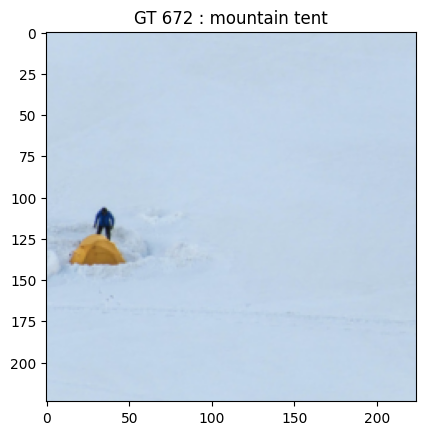

In [9]:
x, label = dataset[42]
plt.title(f"GT {label} : {name_map[label]}")
plt.imshow(unnormalize(x).moveaxis(0, -1))

Predicted class 802 : snowmobile


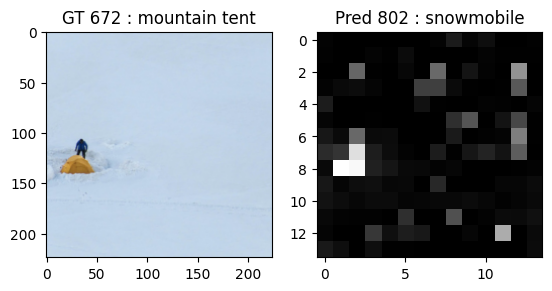

In [10]:
with torch.no_grad():
    output, attention_weights = model(x[None])

pred = output.argmax(dim=1).item()
print(f"Predicted class {pred} : {name_map[pred]}")

plt.subplot(1, 2, 1)
plt.imshow(unnormalize(x).moveaxis(0, -1))
plt.title(f"GT {label} : {name_map[label]}")
plt.subplot(1, 2, 2)
plt.imshow(attention_weights[0], cmap='gray')
plt.title(f"Pred {pred} : {name_map[pred]}")
plt.show()

## Please briefly answer the following based on your intuition. (5 points)
1. Why does the attention map have lower resolution?
2. Browse other samples of the dataset (simply change the idx above or add extra cells below). Is the attention map of final CLS token always localized on the object? Briefly explain your intuition behind what you see.
3. As mentioned above, we're only visualizing the attention weights of the CLS token at the last layer.
   
   Can you think of any problems regarding this? 

   Can you come up with some other way of looking into a decision made by a transformer model?


1. 
   The attention map is lower resolution because the Vision Transformer (ViT) splits the image into non-overlapping patches (e.g., 16×16), not pixels. Each patch becomes a token, so an image like 224×224 results in only 196 tokens. The attention map reflects how the CLS token interacts with these patches, leading to a coarse, patch-level visualization rather than a pixel-level one.

2. 
   Not always, the attention map of final CLS token localizes on the object. In many cases, the attention map does focus on the object, but sometimes it can be scattered or centered on background regions.

   **Intuition:**
   - The model attends to informative regions for classification, which may include context around the object.
   - Early layers might distribute attention broadly, and only later layers refine it toward the object.
   - If the object is small, blurry, or not centered, attention may not fully localize on it.

3. 
   **Limitations:**
   - It only shows what the CLS token attends to, ignoring other tokens' perspectives.
   - Only reflects the last layer, missing insights from earlier stages.
   - Attention weights do not necessarily indicate causal influence on the final prediction.

   **Alternative ways to interpret model decisions:**
   - **Attention rollout**: Combine attention from all layers to get a more holistic view.
   - **Grad-CAM or gradient-based attribution**: Identify which parts of the input most influenced the output.
   - **Visualizing all token attention**: Not just the CLS token, but how all tokens attend to each other.
   - **Probing hidden states**: Train simple classifiers on intermediate representations to see what the model captures at each layer.
